In [3]:
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import json
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
import numpy as np
from tensorflow import keras
import argparse
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model, load_model
import keras.backend as K
from sklearn.model_selection import train_test_split
from data_helpers import Dataloader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import os, pickle
import numpy as np

In [4]:
class bc_LSTM:

	def __init__(self):
		self.classification_mode = "Sentiment"
		self.modality = "bimodal"
		self.PATH = "./data/models/bimodal_weights_sentiment.hdf5"
		self.OUTPUT_PATH = "./data/pickles/bimodal_sentiment.pkl"
		print("Model initiated for bimodal classification")


	def load_data(self,):

		print('Loading data')
		self.data = Dataloader(mode = self.classification_mode)
		self.data.load_bimodal_data()
		self.train_x = self.data.train_dialogue_features
		self.val_x = self.data.val_dialogue_features
		self.test_x = self.data.test_dialogue_features

		self.train_y = self.data.train_dialogue_label
		self.val_y = self.data.val_dialogue_label
		self.test_y = self.data.test_dialogue_label

		self.train_mask = self.data.train_mask
		self.val_mask = self.data.val_mask
		self.test_mask = self.data.test_mask

		self.train_id = self.data.train_dialogue_ids.keys()
		self.val_id = self.data.val_dialogue_ids.keys()
		self.test_id = self.data.test_dialogue_ids.keys()

		self.sequence_length = self.train_x.shape[1]
		
		self.classes = self.train_y.shape[2]
			


	def calc_test_result(self, pred_label, test_label, test_mask):

		true_label=[]
		predicted_label=[]

		for i in range(pred_label.shape[0]):
			for j in range(pred_label.shape[1]):
				if test_mask[i,j]==1:
					true_label.append(np.argmax(test_label[i,j] ))
					predicted_label.append(np.argmax(pred_label[i,j] ))
		print("Classification Report :")
		print(classification_report(true_label, predicted_label, digits=4))
		print('Weighted FScore: \n ', precision_recall_fscore_support(true_label, predicted_label, average='weighted'))

        
        

	def get_bimodal_model(self):

		# Modality specific hyperparameters
		self.epochs = 10
		self.batch_size = 10

		# Modality specific parameters
		self.embedding_dim = self.train_x.shape[2]

		print("Creating Model...")
		
		inputs = Input(shape=(self.sequence_length, self.embedding_dim), dtype='float32')
		masked = Masking(mask_value =0)(inputs)
		lstm = Bidirectional(LSTM(300, activation='tanh', return_sequences = True, dropout=0.4), name="utter")(masked)
		output = TimeDistributed(Dense(self.classes,activation='softmax'))(lstm)

		model = Model(inputs, output)
		return model




	def train_model(self):

		checkpoint = ModelCheckpoint(self.PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

		model = self.get_bimodal_model()
		model.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal')

		early_stopping = EarlyStopping(monitor='val_loss', patience=10)
		model.fit(self.train_x, self.train_y,
		                epochs=self.epochs,
		                batch_size=self.batch_size,
		                sample_weight=self.train_mask,
		                shuffle=True, 
		                callbacks=[early_stopping, checkpoint],
		                validation_data=(self.val_x, self.val_y, self.val_mask))

		self.test_model()



	def test_model(self):

		model = load_model(self.PATH)
		intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("utter").output)

		intermediate_output_train = intermediate_layer_model.predict(self.train_x)
		intermediate_output_val = intermediate_layer_model.predict(self.val_x)
		intermediate_output_test = intermediate_layer_model.predict(self.test_x)

		train_emb, val_emb, test_emb = {}, {}, {}
		for idx, ID in enumerate(self.train_id):
		    train_emb[ID] = intermediate_output_train[idx]
		for idx, ID in enumerate(self.val_id):
		    val_emb[ID] = intermediate_output_val[idx]
		for idx, ID in enumerate(self.test_id):
		    test_emb[ID] = intermediate_output_test[idx]
		pickle.dump([train_emb, val_emb, test_emb], open(self.OUTPUT_PATH, "wb"))

		self.calc_test_result(model.predict(self.test_x), self.test_y, self.test_mask)
		



In [74]:
model_ = bc_LSTM()
model_.load_data()
model_.train_model()

Model initiated for bimodal classification
Loading data
Labels used for this classification:  {'neutral': 0, 'positive': 1, 'negative': 2}
Creating Model...
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.2924
Epoch 00001: val_loss improved from inf to 0.29428, saving model to ./data/models/bimodal_weights_sentiment.hdf5
104/104 [==============================] - 13s 125ms/step - loss: 0.2924 - val_loss: 0.2943
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.2850
Epoch 00002: val_loss did not improve from 0.29428
104/104 [==============================] - 11s 106ms/step - loss: 0.2850 - val_loss: 0.2951
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2844
Epoch 00003: val_loss did not improve from 0.29428
104/104 [==============================] - 11s 104ms/step - loss: 0.2844 - val_loss: 0.2984
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.2832
Epoch 00004: val_loss did not improve from 0

In [75]:
class Sentiment:
    Ngative = "negative"
    Neutral = "neutral"
    Postive = "positive"

class Emotion:
    Joy = "joy"
    Surprise = "surprise"
    Neutral = "neutral"
    Fear = "fear"
    Sadness = "sadness"
    Disgust = "disgust"
    Anger = "anger"

class Dialogue:
    def __init__(self, text, u_id, d_id, speaker, sentiment, emotion):
        self.text = text
        self.u_id = u_id
        self.sentiment = sentiment
        self.d_id = d_id
        self.speaker = speaker
        self.emotion = emotion
        
class DialogueContainer:
    def __init__(self, dialogues):
        self.dialogues = dialogues
        
    def get_text(self):
        return [x.text for x in self.dialogues]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.dialogues]
    
    def get_emotion(self):
        return [x.emotion for x in self.dialogues]
    
    def evenly_distribute(self):
        neutral = list(filter(lambda x: x.sentiment == Sentiment.Neutral, self.dialogues))
        negative = list(filter(lambda x: x.sentiment == Sentiment.Ngative, self.dialogues))
        positive = list(filter(lambda x: x.sentiment == Sentiment.Postive, self.dialogues))
        neutral_shrunk = positive[:len(negative)]
        #self.dialogues = negative + neutral_shrunk 
        random.shuffle(self.dialogues)
        
   

In [76]:
file_name = './data/test_sent_emo.json'

dialogues = []
with open(file_name) as f:
    for line in f:
        dialogue = json.loads(line)
        dialogues.append(Dialogue(dialogue['Utterance'], dialogue['Utterance_ID'],dialogue['Dialogue_ID'],dialogue['Speaker'],dialogue['Sentiment'],dialogue['Emotion']))
        
test = dialogues
test[1].text

'Oh. That’s so Monica can keep track. That way if one on them is missing, she can be like, ‘Where’s number 27?!’'

In [77]:
file_name = './data/train_sent_emo.json'

dialogues = []
with open(file_name) as f:
    for line in f:
        dialogue = json.loads(line)
        dialogues.append(Dialogue(dialogue['Utterance'], dialogue['Utterance_ID'],dialogue['Dialogue_ID'],dialogue['Speaker'],dialogue['Sentiment'],dialogue['Emotion']))
training = dialogues    
training[1].emotion

'neutral'

In [78]:
train_container = DialogueContainer(training)
test_container = DialogueContainer(test)


train_x = train_container.get_text()
train_y = train_container.get_sentiment()
train_z = train_container.get_emotion()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()
test_z = test_container.get_emotion()

print("------ Samples of Sentiment ----")
print("Number of total positive samples: "+str(train_y.count(Sentiment.Postive)))
print("Number of total negative samples: "+str(train_y.count(Sentiment.Ngative)))
print("Number of total neutral samples: "+str(train_y.count(Sentiment.Neutral)))
print(" ")
print("------ Samples of Emotion ------")
print("Number of total joy samples: "+ str(train_z.count(Emotion.Joy)))
print("Number of total surprise samples: "+ str(train_z.count(Emotion.Surprise)))
print("Number of total neutral samples: "+ str(train_z.count(Emotion.Neutral)))
print("Number of total fear samples: "+ str(train_z.count(Emotion.Fear)))
print("Number of total sadness samples: "+ str(train_z.count(Emotion.Sadness)))
print("Number of total disgust samples: "+ str(train_z.count(Emotion.Disgust)))
print("Number of total anger samples: "+ str(train_z.count(Emotion.Anger)))

------ Samples of Sentiment ----
Number of total positive samples: 2322
Number of total negative samples: 2930
Number of total neutral samples: 4680
 
------ Samples of Emotion ------
Number of total joy samples: 1738
Number of total surprise samples: 1194
Number of total neutral samples: 4680
Number of total fear samples: 264
Number of total sadness samples: 681
Number of total disgust samples: 270
Number of total anger samples: 1105


In [79]:
vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
#print(train_x_vectors[0])


also I was the point person on my company’s transition from the KL-5 to GR-6 system.


In [80]:
clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)
print("Result of linear")

print("Correctness of navy bayes: "+str(clf_svm.score(test_x_vectors, test_y)))

#clf_svm.predict(test_x_vectors[0])


Result of linear
Correctness of navy bayes: 0.5555555555555556


In [81]:
clf_gnb = DecisionTreeClassifier()
clf_gnb.fit(train_x_vectors, train_y)
clf_gnb.fit(train_x_vectors, train_y)
print("Result of navy bayes")

print("Correctness of navy bayes: "+str(clf_gnb.score(test_x_vectors, test_y)))

#clf_gnb.predict(test_x_vectors[0])

Result of navy bayes
Correctness of navy bayes: 0.4854406130268199


In [82]:
clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

print("Correctness of navy bayes: "+str(clf_log.score(test_x_vectors, test_y)))


#clf_log.predict(test_x_vectors[0])

Correctness of navy bayes: 0.557088122605364


/Users/emelyxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
nega = os.path.join('./data/rps/negative')
neut = os.path.join('./data/rps/neutral')
posi = os.path.join('./data/rps/positive')

print('total training negative emotion images:', len(os.listdir(nega)))
print('total training neural emotion images:', len(os.listdir(neut)))
print('total training positive emotion images:', len(os.listdir(posi)))

nega_files = os.listdir(nega)
neut_files = os.listdir(neut)
posi_files = os.listdir(posi)


total training negative emotion images: 184
total training neural emotion images: 150
total training positive emotion images: 150


Some examples of the train images:


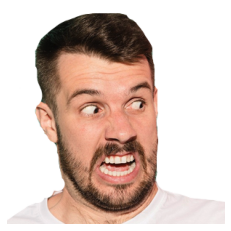

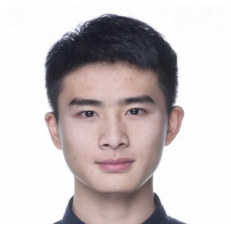

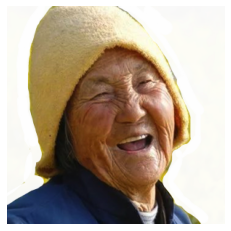

In [84]:
%matplotlib inline

pic_index = 3



next_nega = [os.path.join(nega, fname) 
                for fname in nega_files[pic_index-1:pic_index]]
next_neut = [os.path.join(neut, fname) 
                for fname in neut_files[pic_index-1:pic_index]]
next_posi = [os.path.join(posi, fname) 
                for fname in posi_files[pic_index-1:pic_index]]

print("Some examples of the train images:")
for i, img_path in enumerate(next_nega + next_neut + next_posi):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()


In [89]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator                                                                                                                                                                                                                                            

TRAINING_DIR = "./data/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=5,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "./data/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=15, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")

Found 481 images belonging to 3 classes.
Found 447 images belonging to 3 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 128)       0         
______________________________________

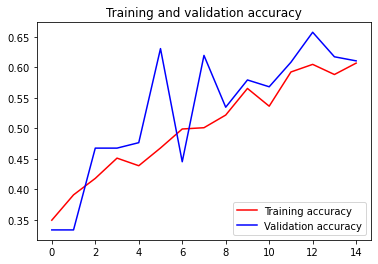

<Figure size 432x288 with 0 Axes>

In [90]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

neg net pos
[[0. 0. 1.]]


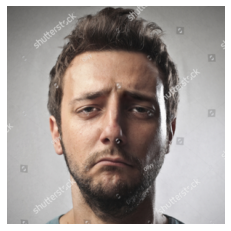

In [87]:
import numpy as np
import os

from keras.preprocessing import image

path = './data/test_images/nt10.png'
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
#print(fn)

print("neg net pos")
print(classes)


img_ = mpimg.imread(path)
plt.imshow(img_)
plt.axis('Off')
plt.show()